In [3]:
from sentinelhub import SHConfig

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")


In [4]:
# make an account and enter the relevant info
config.instance_id = 'your_instance_id'
config.sh_client_secret = 'your_client_secret'
config.sh_client_id = 'your_client_id'

config.save()
config

In [62]:
# define latitude & longitude for your location
betsiboka_coords_wgs84 = [12.804867,51.334495,12.840150,51.310916]


resolution = 20
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {betsiboka_size} pixels')

Image shape at 20 m resolution: (127, 127) pixels


In [64]:
# command for retrieving the data
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04", "B08", "CLM"]
            }],
            output: {
                bands: 5
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02, sample.B08];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2018-01-01', '2019-01-01'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)

In [65]:
def get_true_color_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order='leastCC'
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=betsiboka_bbox,
        size=betsiboka_size,
        config=config
    )

In [71]:
# time interval & boundary
start = datetime.datetime(2017,1,28)
end = datetime.datetime(2017,11,28)
n_chunks = 61

tdelta = (end - start) / n_chunks
edges = [(start + i*tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i+1]) for i in range(len(edges)-1)]

print('Monthly time windows:\n')
for slot in slots:
    print(slot)

Monthly time windows:

('2017-01-28', '2017-02-01')
('2017-02-01', '2017-02-06')
('2017-02-06', '2017-02-11')
('2017-02-11', '2017-02-16')
('2017-02-16', '2017-02-21')
('2017-02-21', '2017-02-26')
('2017-02-26', '2017-03-03')
('2017-03-03', '2017-03-08')
('2017-03-08', '2017-03-13')
('2017-03-13', '2017-03-18')
('2017-03-18', '2017-03-23')
('2017-03-23', '2017-03-28')
('2017-03-28', '2017-04-02')
('2017-04-02', '2017-04-07')
('2017-04-07', '2017-04-12')
('2017-04-12', '2017-04-17')
('2017-04-17', '2017-04-22')
('2017-04-22', '2017-04-27')
('2017-04-27', '2017-05-02')
('2017-05-02', '2017-05-07')
('2017-05-07', '2017-05-12')
('2017-05-12', '2017-05-17')
('2017-05-17', '2017-05-22')
('2017-05-22', '2017-05-27')
('2017-05-27', '2017-06-01')
('2017-06-01', '2017-06-06')
('2017-06-06', '2017-06-11')
('2017-06-11', '2017-06-16')
('2017-06-16', '2017-06-21')
('2017-06-21', '2017-06-26')
('2017-06-26', '2017-07-01')
('2017-07-01', '2017-07-06')
('2017-07-06', '2017-07-11')
('2017-07-11', '2017

In [72]:
# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

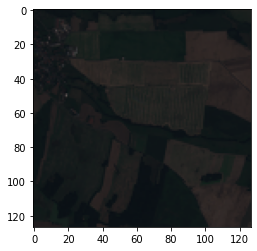

In [79]:
# test that it works
plt.imshow(data[40][:,:,:3])

In [88]:
# save as an npz file
dataNew = np.asarray(data).transpose(1,2,3,0)

np.save("sentinel_data.npz", dataNew, allow_pickle=True)

In [89]:
dataNew.shape

(127, 127, 4, 60)